In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from scipy.special import boxcox1p
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [260]:
data = pd.read_csv('data/importaciones_gasolina.csv')

# Seleccionando columnas de interes
columns = ['Fecha', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gas licuado de petróleo', 'Gasolina regular', 'Gasolina superior', 'Diesel alto azufre']
data = data[columns]

# Renombrando columnas
new_column_names = ['fecha', 'diesel_bajo_azufre', 'diesel_ultra_bajo_azufre', 'gas_licuado_petroleo', 'gasolina_regular', 'gasolina_superior', 'diesel_alto_azufre']
data.columns = new_column_names

# Eliminando filas con valores nulos
data = data.dropna()

# Convirtiendo fecha a formato datetime
data['fecha'] = pd.to_datetime(data['fecha'])

data


/var/folders/wd/kpmqk46j1wq467f_h9w8l5440000gn/T/ipykernel_12212/1056520668.py:15: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,fecha,diesel_bajo_azufre,diesel_ultra_bajo_azufre,gas_licuado_petroleo,gasolina_regular,gasolina_superior,diesel_alto_azufre
0,2001-01-01,0.00,0.00,"194,065.74","177,776.50","373,963.96","566,101.99"
1,2001-02-01,0.00,0.00,"170,703.38","123,115.99","243,091.07","489,525.80"
2,2001-03-01,0.00,0.00,"161,837.37","161,726.42","312,084.38","575,559.68"
3,2001-04-01,0.00,0.00,"163,048.64","127,338.74","285,054.89","437,745.42"
4,2001-05-01,0.00,0.00,"171,518.86","168,730.19","300,913.67","552,609.13"
...,...,...,...,...,...,...,...
264,2023-01-01,"1,442,099.08","45,074.97","497,780.69","909,391.13","578,792.14",0.00
265,2023-02-01,"1,267,967.39",0.00,"652,984.71","725,101.20","685,183.06",0.00
266,2023-03-01,"1,317,519.91","4,985.21","711,978.35","803,262.67","633,849.05",0.00
267,2023-04-01,"1,417,182.73","21,503.98","647,666.30","922,032.39","572,201.36",0.00


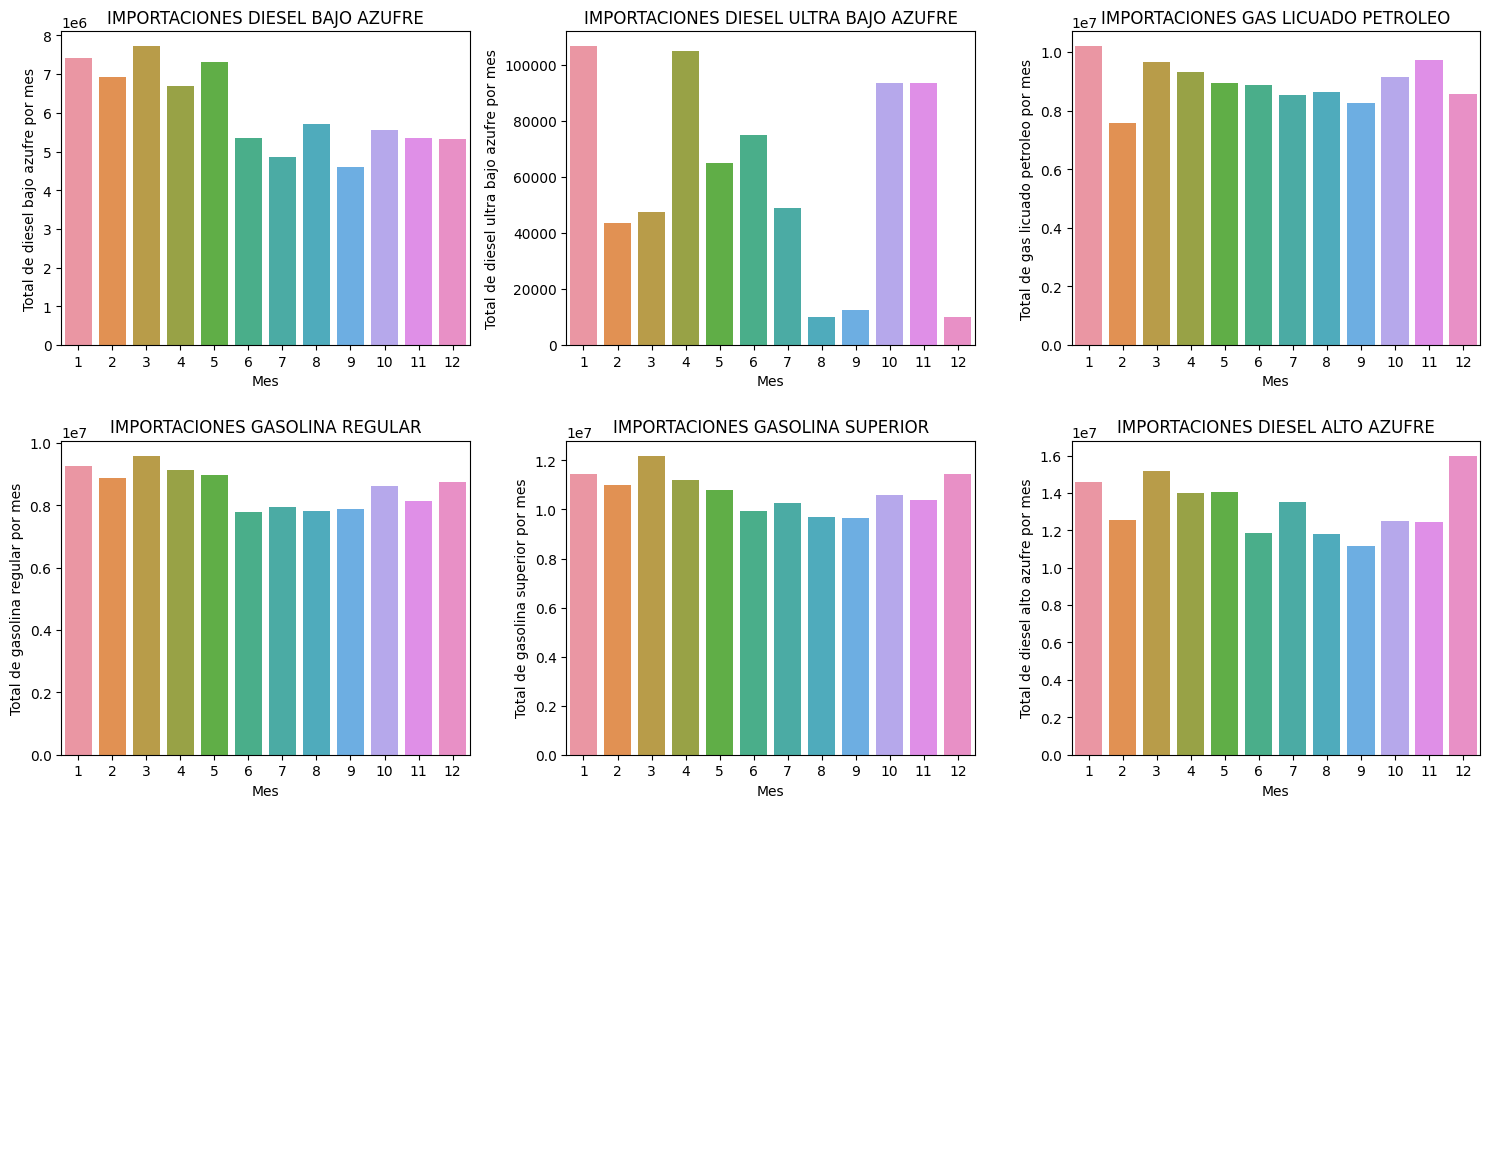

In [261]:
data['mes'] = data['fecha'].dt.month
columns = [col for col in data.columns if col not in ['fecha', 'mes']]

frequency_rows = len(columns) // 3 + 1
frequency_cols = 3

fig, axs = plt.subplots(frequency_rows, frequency_cols, figsize=(15, 4* frequency_rows))
axs = axs.flatten()

for ax, column in zip(axs, columns):
    try:
        data[column] = pd.to_numeric(data[column].str.replace(',', ''))
    except AttributeError:
        pass

    monthly_values = data.groupby('mes')[column].sum()
    
    sns.barplot(x=monthly_values.index, y=monthly_values.values, ax=ax)
    ax.set_title(f"IMPORTACIONES {' '.join(column.split('_')).upper()}")
    ax.set_xlabel('Mes')
    ax.set_ylabel(f"Total de {' '.join(column.split('_'))} por mes")

for ax in axs[len(columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [262]:
data['anio'] = data['fecha'].dt.year
data['mes'] = data['fecha'].dt.month

frequency_cols = 2
columns = [col for col in data.columns if col not in ['fecha', 'mes', 'anio']]
fig = make_subplots(rows=frequency_rows, cols=frequency_cols, subplot_titles=[f"Comportamiento de {' '.join(column.split('_'))} (2001-2023)" for column in columns], vertical_spacing=0.12)

for i, column in enumerate(columns):
    try:
        data[column] = pd.to_numeric(data[column].str.replace(',', ''))
    except AttributeError:
        pass

    year_values = data.groupby('anio')[column].sum()
    trace = go.Scatter(x=year_values.index, y=year_values.values, name=f"Total {' '.join(column.split('_'))}", mode='lines+markers')    
    fig.add_trace(trace, row=(i // frequency_cols) + 1, col=(i % frequency_cols) + 1)

height_p = 350 
height_p = height_p * frequency_rows

fig.update_layout(showlegend=False, height=height_p)
fig.update_xaxes(title_text="Año")
fig.update_yaxes(title_text=f"Total")

fig.show()


## Serie - Importación mensual de gasolina diesel bajo azufre

- Inicio: 2018-01-01
- Fin: 2023-05-01
- Frecuencia: Mensual

In [263]:
data_dba = data[data['fecha'] >= '2018-01-01']
data_daa = data[data['fecha'] <= '2017-12-01']

data_dba = data_dba.rename(columns={'diesel_bajo_azufre': 'diesel'})
data_daa = data_daa.rename(columns={'diesel_alto_azufre': 'diesel'})

data_diesel = pd.concat([data_dba, data_daa], axis=0)
data_diesel = data_diesel.sort_values(by='fecha')

data_diesel = data_diesel.drop(columns=['diesel_alto_azufre', 'diesel_bajo_azufre', 'diesel_ultra_bajo_azufre'])

In [264]:
data_diesel.freq = 'M'

data_diesel = data_diesel.copy() 
data_diesel['media_movil'] = data_diesel['diesel'].rolling(window=12).mean()
rolling_mean = data_diesel['diesel'].rolling(window=12).mean()

fig = px.line(data_diesel, x='fecha', y='diesel', labels={'diesel': 'Cantidad de diesel Bajo Azufre'}, title='Diesel Bajo Azufre por mes cada año', markers=True)
fig.add_scatter(x=data_diesel['fecha'], y=rolling_mean, mode='lines', name='Media móvil - 12 meses')

fig.update_xaxes(tickformat="%Y", title_text='Año')
fig.update_traces(line=dict(width=2.5))
fig.show()


A primera vista no se observa estacionaridad en media ni en varianza.

### Descomposición de la serie

In [265]:
d_serie_dba = seasonal_decompose(data_diesel.set_index('fecha')['diesel'].astype(float))
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Tendencia', 'Estacionalidad', 'Aleatoriedad'))

fig.add_trace(go.Scatter(x=d_serie_dba.trend.index, y=d_serie_dba.trend, mode='lines', name='Tendencia'), row=1, col=1)
fig.add_trace(go.Scatter(x=d_serie_dba.seasonal.index, y=d_serie_dba.seasonal, mode='lines', name='Estacionalidad'), row=2, col=1)
fig.add_trace(go.Scatter(x=d_serie_dba.resid.index, y=d_serie_dba.resid, mode='lines', name='Aleatoriedad'), row=3, col=1)

fig.update_layout(title='Descomposición de la serie de tiempo - Diesel Bajo Azufre')
fig.show()

Hay una tendencia evidente y una estacionalidad notable. En cuanto al componente de aleatoriedad, no se identifica ningún patrón.

### Transformación de la serie
La serie requiere una transformación de tipo box-cox dado que no es estacionaria en varianza.

In [266]:
data_diesel['diesel_boxcox'] = boxcox1p(data_diesel['diesel'], 0.49)
fig = px.line(data_diesel, x='fecha', y='diesel_boxcox', title='Diesel - Transformación box cox', markers=True)

fig.show()


Se ve un ligero cambio al momento de aplicar box-cox.

### Estacionaridad en media

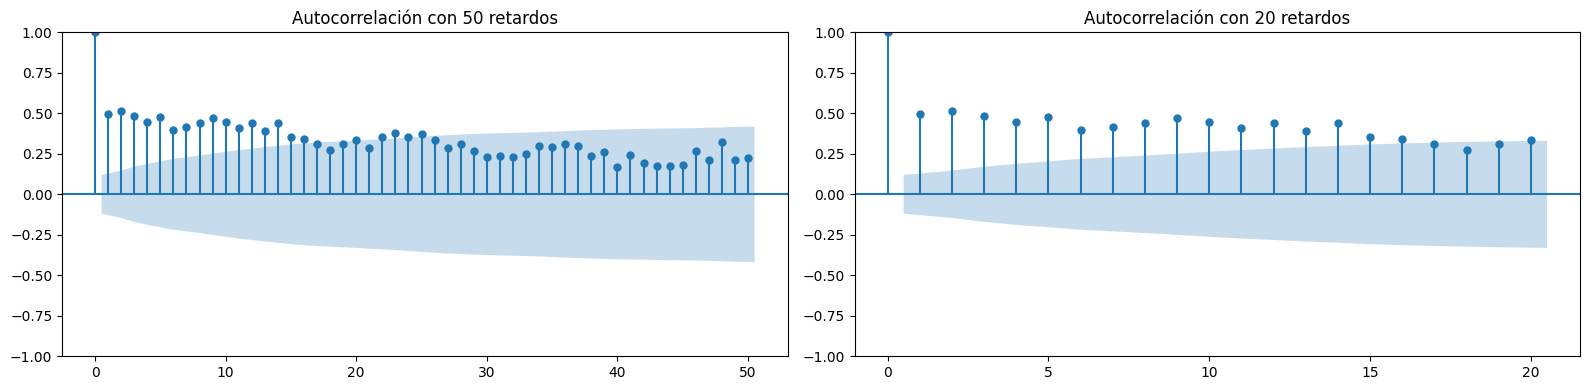

In [267]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(data_diesel['diesel_boxcox'], lags=50, ax=ax[0])
ax[0].set_title("Autocorrelación con 50 retardos")

plot_acf(data_diesel['diesel_boxcox'], lags=20, ax=ax[1])
ax[1].set_title("Autocorrelación con 20 retardos")

plt.tight_layout()
plt.show()

In [268]:
print('Resultados del Test de Dickey Fuller')
dfTest2 = adfuller(data_diesel['diesel_boxcox'], autolag='AIC')
salidaDf2 = pd.Series(dfTest2[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest2[4].items():
        salidaDf2['Critical Value (%s)'%key] = value
print(salidaDf2)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.373701
p-value                        0.594817
# de retardos usados          13.000000
# de observaciones usadas    255.000000
Critical Value (1%)           -3.456257
Critical Value (5%)           -2.872942
Critical Value (10%)          -2.572846
dtype: float64


En base al gráfico de autocorrelación y el test de Dickey Fuller se confirma que la serie no es estacionaria en media. Porque se puede rechazar la hipótesis nula del test de Dickey Fuller ya que el valor de p (0.594817) es mayor a 0.05, lo cual también indica que puede haber más de una raíz unitaria. Por tanto, es necesario hacer una diferenciación.

In [269]:
data_diesel['diesel_boxcox_diff'] = data_diesel['diesel_boxcox'].diff()
data_diesel.dropna(subset=['diesel_boxcox_diff'], inplace=True)

dfTest2 = adfuller(data_diesel['diesel_boxcox_diff'], autolag='AIC')
salidaDf2 = pd.Series(dfTest2[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest2[4].items():
        salidaDf2['Critical Value (%s)'%key] = value
print(salidaDf2)

Estadístico de prueba       -8.315823e+00
p-value                      3.683336e-13
# de retardos usados         1.200000e+01
# de observaciones usadas    2.550000e+02
Critical Value (1%)         -3.456257e+00
Critical Value (5%)         -2.872942e+00
Critical Value (10%)        -2.572846e+00
dtype: float64


Despues de aplicar una diferenciación de orden 1, se obtiene una serie estacionaria en media con un valor de 3.742521e-13, por lo que se puuede rechazar la  hipótesis nula de Dickey-Fuller.

### Parámetros p, d y q

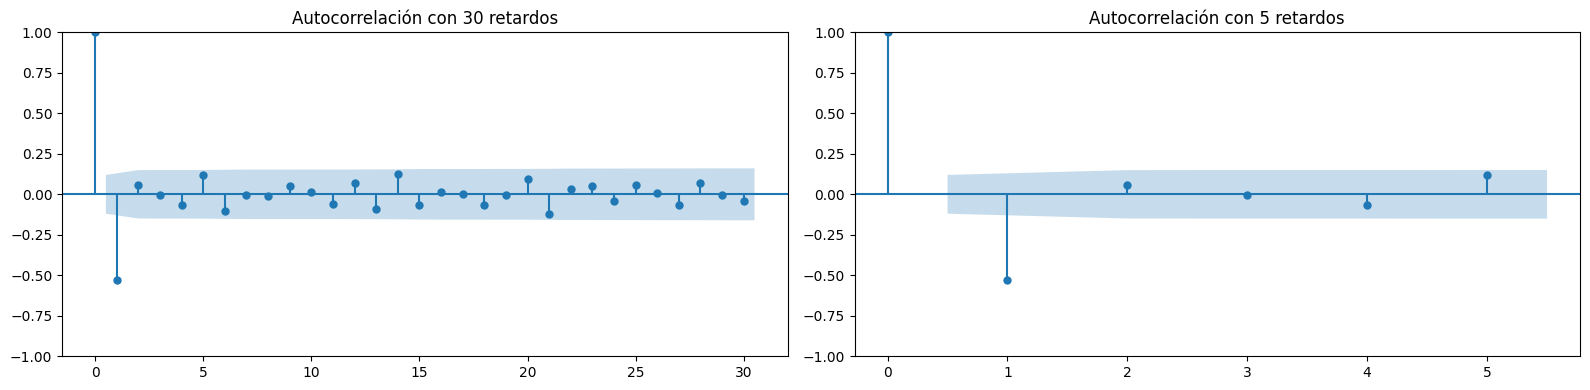

In [270]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

plot_acf(data_diesel['diesel_boxcox_diff'].dropna(), lags=30, title='Función de Autocorrelación con 30 retardos', ax=ax[0])
ax[0].set_title("Autocorrelación con 30 retardos")

plot_acf(data_diesel['diesel_boxcox_diff'].dropna(), lags=5, title='Función de Autocorrelación con 5 retardos', ax=ax[1])
ax[1].set_title("Autocorrelación con 5 retardos")

plt.tight_layout()
plt.show()


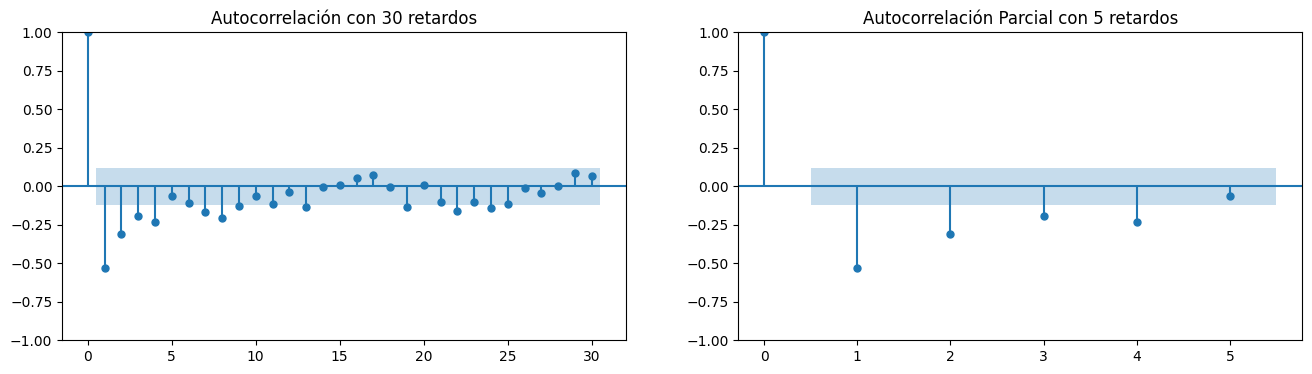

In [271]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_pacf(data_diesel['diesel_boxcox_diff'], lags=30, title='Función de Autocorrelación Parcial 30 retardos', alpha=0.05, ax=ax[0])
ax[0].set_title("Autocorrelación con 30 retardos")

plot_pacf(data_diesel['diesel_boxcox_diff'], lags=5, title='Función de Autocorrelación 30 retardos', alpha=0.05, ax=ax[1])
ax[1].set_title("Autocorrelación Parcial con 5 retardos")

plt.show()


p = 1, q = 1, d = 1

### Estacionalidad

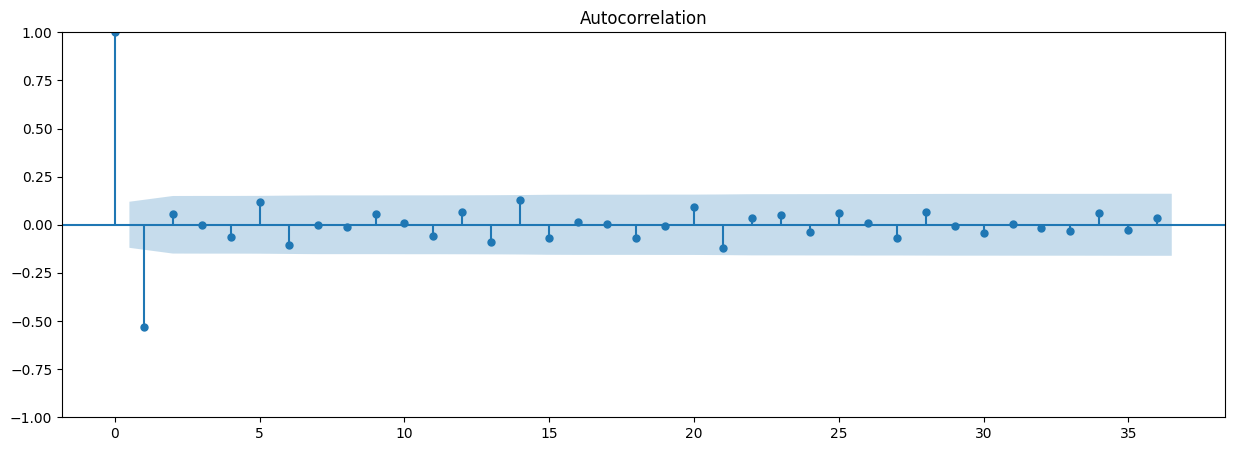

In [272]:
plot_acf(data_diesel['diesel_boxcox_diff'], lags=36)
plt.show()

Se observa que hay estacionalidad cada 5 meses, por tanto, se debe agregar el componente estacional. 

In [273]:
data_diesel['diesel_boxcox_diff_5'] = data_diesel['diesel_boxcox_diff'].diff(5)
data_diesel.dropna(subset=['diesel_boxcox_diff_5'], inplace=True)

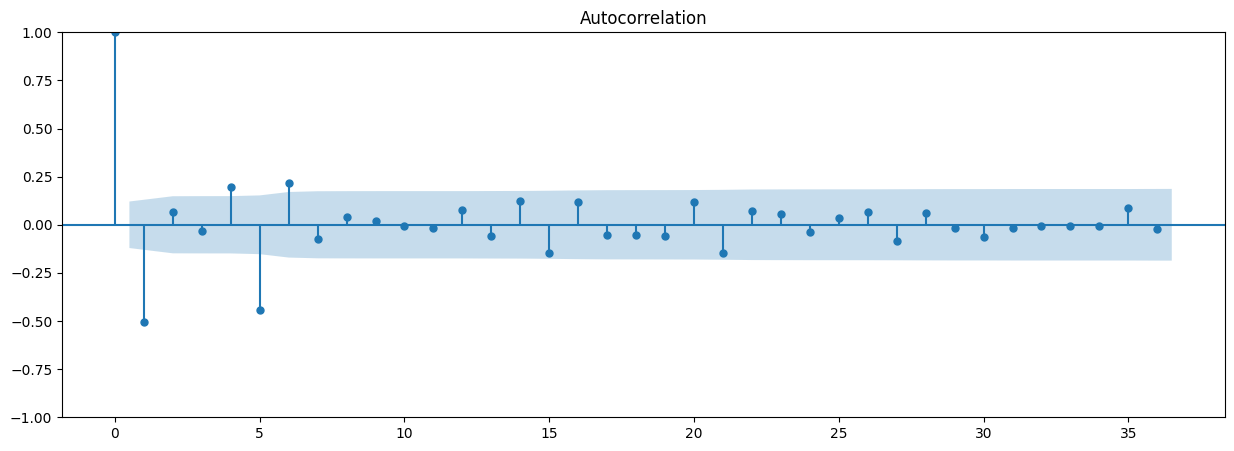

In [274]:
plot_acf(data_diesel['diesel_boxcox_diff_5'], lags=36)
plt.show()

Los componentes se anulan los coeficientes después de p=6. Por tanto, p=6, d=1, q=0.

In [275]:
data_diesel['fecha'] = pd.to_datetime(data_diesel['fecha'])
data_diesel.set_index('fecha', inplace=True)
data_diesel.index.freq = 'MS'


modelo_import_diesel = SARIMAX(data_diesel['diesel_boxcox'], order=(1,1,1), seasonal_order=(6,1,0,5), enforce_stationarity=False, enforce_invertibility=False)
res_mid = modelo_import_diesel.fit()
print(res_mid.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91930D+00    |proj g|=  1.11351D-01


 This problem is unconstrained.



At iterate    5    f=  5.87062D+00    |proj g|=  1.94863D-02

At iterate   10    f=  5.87001D+00    |proj g|=  1.56922D-03

At iterate   15    f=  5.86956D+00    |proj g|=  9.60886D-03

At iterate   20    f=  5.86484D+00    |proj g|=  2.94410D-02

At iterate   25    f=  5.78350D+00    |proj g|=  1.62484D-01

At iterate   30    f=  5.77106D+00    |proj g|=  2.24115D-02

At iterate   35    f=  5.77081D+00    |proj g|=  2.12886D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     45      1     0     0   3.428D-05   5.771D+00
  F =   5.7708061273195534     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

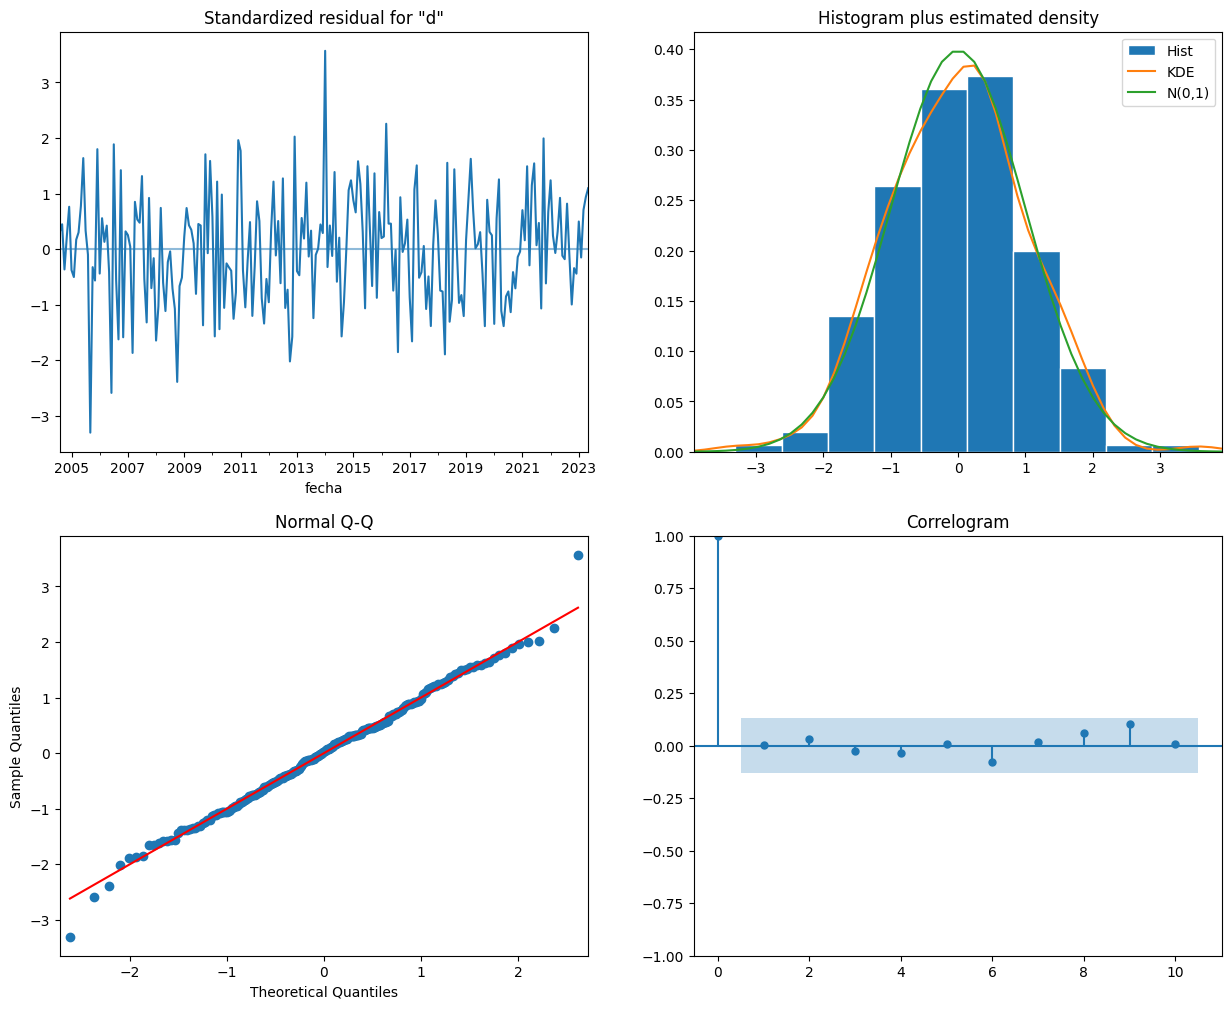

In [276]:
res_mid.plot_diagnostics(figsize=(15, 12))
plt.show()